# Predicting Ethiopian Vehicle Insurance Premiums

- The goal of this project is to clean, analyse and predict vehicle insurance premiums of the state-owned Ethiopian Insurance Corporation (one of the biggest insurance companies in Ethiopia).
- The dataset we'll use describes vehicles, their insurance premiums and other insurance related atributes from July 2011 to June 2018. It can be found on [Mendeley Data](https://data.mendeley.com/datasets/34nfrk36dt/1).



#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, kstest
import sklearn as sk
from sklearn.linear_model import LinearRegression
from fuzzywuzzy import process

import requests
from bs4 import BeautifulSoup

#%config InlineBackend.figure_formats = ['svg']

insurance_data_1 = pd.read_csv("insuranceData/motor_data11-14lats.csv")
insurance_data_2 = pd.read_csv("insuranceData/motor_data14-2018.csv")

### Predefined function 

In [2]:
def plot_counts_and_premiums(ax, count_series, premium_series, xlabel):
    index = count_series.index
    x = np.arange(len(index))
    w = 0.4

    ax.bar(x - w/2, count_series.values, w, label='Policy Count', color='tab:red')
    ax.set_ylabel('Policy Count', color='tab:red')
    ax.tick_params(axis='y', labelcolor='tab:red')
    ax.set_xlabel(xlabel)
    ax.set_xticks(x)
    ax.set_xticklabels(index)

    ax2 = ax.twinx()
    ax2.bar(x + w/2, premium_series.loc[index].values, w, label='Premium Sum', color='tab:blue')
    ax2.set_ylabel('Premium Sum', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

## Dataset overview

Both of the provided dataset files include the same entry attributes and differ only in entry dates. They will need to be merged.

In [3]:
insurance_data = pd.concat([insurance_data_1, insurance_data_2], ignore_index=True)

print(insurance_data.shape)

(802036, 16)


We have 802036 insurance policy records and 16 policy related attributes.

Now let's look whether the provided attributes have been read correctly.

In [4]:
insurance_data.head(10)

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
0,0,08-AUG-13,07-AUG-14,08,1202,519755.22,7209.140,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
1,0,08-AUG-12,07-AUG-13,08,1202,519755.22,7203.890,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
2,0,08-AUG-11,07-AUG-12,08,1202,519755.22,7045.804,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
3,0,08-JUL-11,07-AUG-11,08,1202,519755.22,287.250,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
4,0,08-AUG-13,07-AUG-14,08,1202,285451.24,4286.900,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43
5,0,08-AUG-12,07-AUG-13,08,1202,285451.24,4286.650,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,26916.44
6,0,08-AUG-11,07-AUG-12,08,1202,285451.24,4123.564,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,NaN
7,0,08-JUL-11,07-AUG-11,08,1202,285451.24,155.010,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,NaN
8,0,08-JUL-12,07-JUL-13,11,1201,200000.00,3452.650,5000030346,1982.0,10.0,NaN,Station Wagones,4164.0,TOYOTA,Private,NaN
9,0,08-AUG-11,07-JUL-12,11,1201,200000.00,3077.540,5000030346,1982.0,10.0,NaN,Station Wagones,4164.0,TOYOTA,Private,NaN


There are multiple entries regarding the same vehicle as it has to be reinsured every year. That can lead to up to 7 entries for the same vehicle with only the premium amout fluctuating.

In [5]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802036 entries, 0 to 802035
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEX                802036 non-null  int64  
 1   INSR_BEGIN         802036 non-null  object 
 2   INSR_END           802036 non-null  object 
 3   EFFECTIVE_YR       802032 non-null  object 
 4   INSR_TYPE          802036 non-null  int64  
 5   INSURED_VALUE      802036 non-null  float64
 6   PREMIUM            802015 non-null  float64
 7   OBJECT_ID          802036 non-null  int64  
 8   PROD_YEAR          801867 non-null  float64
 9   SEATS_NUM          801801 non-null  float64
 10  CARRYING_CAPACITY  603837 non-null  float64
 11  TYPE_VEHICLE       802036 non-null  object 
 12  CCM_TON            802028 non-null  float64
 13  MAKE               802031 non-null  object 
 14  USAGE              802036 non-null  object 
 15  CLAIM_PAID         60145 non-null   float64
dtypes:

Columns seem to have been read correctly. Let's now look at the values in individual columns.

### Sex

In [6]:
insurance_data["SEX"].value_counts()

SEX
0    415297
1    318650
2     68089
Name: count, dtype: int64

In the dataset, there are 3 unique sex values with 0 being legal entities, 1 - males and 2 - females. The number of insurance contracts in which men are the policyholders is 4.67 times greater that the number of contracts with female policyholders. That is due to women being less likely to have a drivers license in Ethiopia.

Let's remap the value for better clarity.

In [7]:
sex_mapping = {0:'LEGAL ENTITY', 1:'MALE', 2:'FEMALE'}

insurance_data["SEX"] = insurance_data["SEX"].map(sex_mapping)

insurance_data["SEX"].value_counts()

SEX
LEGAL ENTITY    415297
MALE            318650
FEMALE           68089
Name: count, dtype: int64

### Insurance start & end date

In [8]:
insurance_data["INSR_BEGIN"].value_counts()

INSR_BEGIN
08-JUL-17    16754
08-JUL-16    15640
08-JUL-11    15215
08-JUL-15    13464
08-JUL-14    13121
             ...  
29-MAY-13        3
28-SEP-15        3
03-MAR-15        1
12-SEP-14        1
12-SEP-12        1
Name: count, Length: 2556, dtype: int64

In [9]:
insurance_data["INSR_END"].value_counts()

INSR_END
07-JUL-18    17378
07-JUL-17    15827
07-JUL-16    14864
07-JUL-13    13594
07-JUL-15    13248
             ...  
19-OCT-11        1
03-DEC-11        1
01-MAY-12        1
04-SEP-11        1
21-AUG-11        1
Name: count, Length: 2834, dtype: int64

There do not seem to be any obvious errors in the data. Yet, we must check whether there are entries where the insurance start date is later than the end date.

In [10]:
insurance_data["INSR_BEGIN"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y")

insurance_data["INSR_END"] = pd.to_datetime(insurance_data["INSR_END"], format="%d-%b-%y")

end_greater_start = insurance_data["INSR_BEGIN"] > insurance_data["INSR_END"]
length = len(end_greater_start[end_greater_start == True])
length

0

No end values are earlier than start values. We can now visualize the variable data.

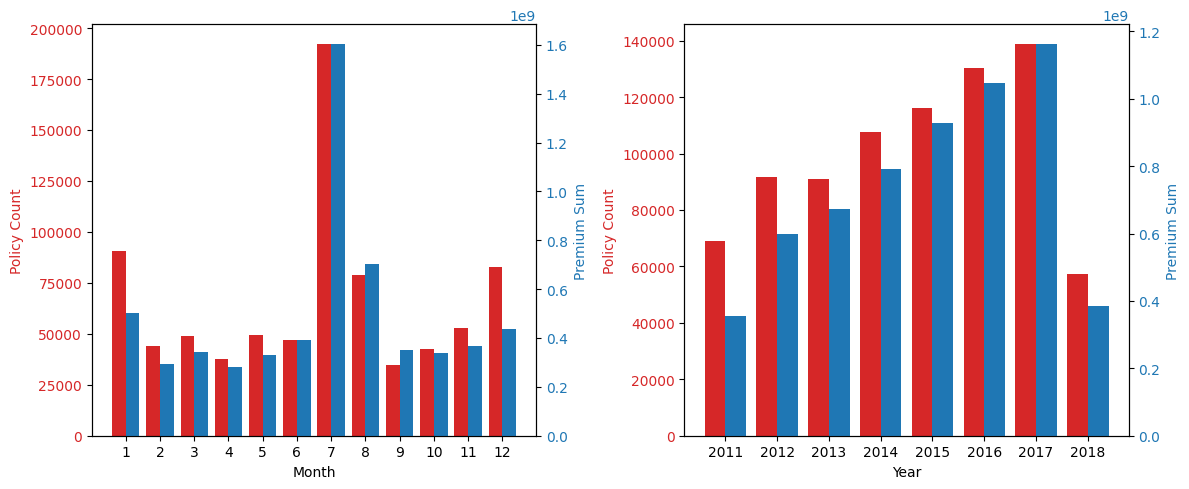

In [11]:
insurance_data["INSR_START_MONTH"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y").dt.month
insurance_data["INSR_START_YEAR"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y").dt.year

start_months = insurance_data["INSR_START_MONTH"].value_counts().sort_index()
start_months_premium = insurance_data.groupby("INSR_START_MONTH")["PREMIUM"].sum()

start_years = insurance_data["INSR_START_YEAR"].value_counts().sort_index()
start_years_premium = insurance_data.groupby("INSR_START_YEAR")["PREMIUM"].sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_counts_and_premiums(axes[0], start_months, start_months_premium, 'Month')
plot_counts_and_premiums(axes[1], start_years, start_years_premium, 'Year')

fig.tight_layout()
plt.show()

From the charts it becomes clear that policy count closely correlates with premium sums with regard to both the month and the year of the insurance start date. One month, July, stand out as the month in which the most policies are introduced. In terms of the trend regarding the year, there is a clear pattern of growth from 2011 to 2017 and a sharp drop off of new policies in 2018. The drop off can be explained by the end of data collection period being June of 2018. We can check whether growth in the month of June in the respective years is equally as rapid.

In [12]:
before_june = insurance_data[(insurance_data["INSR_START_YEAR"].isin([2017, 2018])) & (insurance_data["INSR_START_MONTH"] < 7)]

before_june.groupby("INSR_START_YEAR").size().reset_index(name='Policy Count')

,INSR_START_YEAR,Policy Count
0,2017,55693
1,2018,57300


The pace of growth is about the same.

Let's also create a dummy variable for insurance start days.

In [13]:
insurance_data["INSR_START_DAY"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y").dt.day

### Effective year

In [14]:
insurance_data["EFFECTIVE_YR"].value_counts()

EFFECTIVE_YR
11    199888
12     86791
15     75484
14     74001
16     68866
       ...  
8R         1
RS         1
IN         1
/1         1
EA         1
Name: count, Length: 151, dtype: int64

The effective year variable indicates what year the policy came into effect (was first insured with the company). There are numerous records that indicate a year before the historic start date of the dataset (2011).

Yet, the column contains values that are not indicative of a number and should be removed. Since there are a total of 802036 records, we can afford to lose quite a few. We also need to convert the years into a four-digit number as a two-digit year encoding is only common on legacy data storage systems.

In [15]:
insurance_data = insurance_data[insurance_data["EFFECTIVE_YR"].astype(str).str.match(r"^\d{2}$")]

def convert_year(y):
    y = int(y)
    if y > 18:
        return 1900 + y
    else:
        return 2000 + y

insurance_data["EFFECTIVE_YR_FULL"] = insurance_data["EFFECTIVE_YR"].apply(convert_year)

insurance_data.shape

(800865, 20)

After cleaning the effective year column, we have lost 1171 rows.

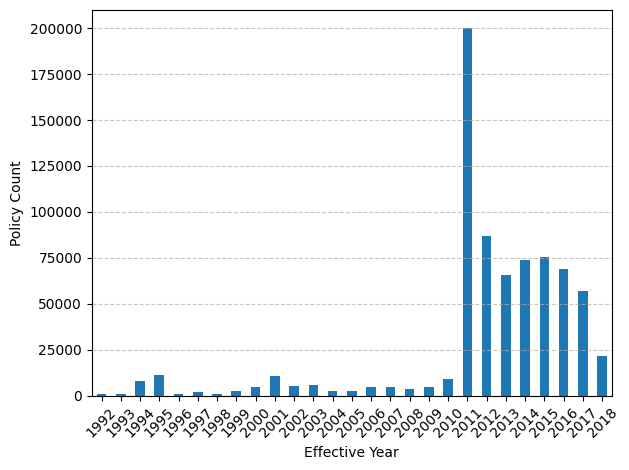

In [16]:
year_counts = insurance_data["EFFECTIVE_YR_FULL"].value_counts().sort_index()

year_counts = year_counts[
    (year_counts.index >= 1992) &
    (year_counts.index <= 2018)
]

year_counts.plot(kind='bar')
plt.xlabel("Effective Year")
plt.ylabel("Policy Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
year_counts = insurance_data["EFFECTIVE_YR_FULL"].value_counts().sort_index()
print(year_counts)

EFFECTIVE_YR_FULL
1919      394
1920      593
1921      532
1922      454
1923      488
        ...  
2014    74001
2015    75484
2016    68866
2017    57060
2018    21547
Name: count, Length: 100, dtype: int64


The data shows that most of the insured vehicles were first insured in 2011 and later. After contacting the postdoctoral fellow that published the dataset, I was informed that the meaning of this variable is not very well documented. There are values of 1947 and prior, eventhough, in Ethiopia, the first motor insurance was issued in 1947. This variable will be dropped.

In [18]:
insurance_data.drop(columns=["EFFECTIVE_YR", "EFFECTIVE_YR_FULL"], inplace=True)

### Insurance type

In [19]:
insurance_data["INSR_TYPE"].value_counts()

INSR_TYPE
1202    593519
1201    207011
1204       335
Name: count, dtype: int64

There are a total of three types of insurance: 1201 - private, 1202 - commercial and 1204 - motor trade road risk (for motor trade workers that drive vehicles they do not personally own, such as mechanics when testing repaired vehicles).

Let's change the values so they make more sense.

In [20]:
insurance_type_mapping = {1202:'PRIVATE', 1201:'COMMERCIAL', 1204:'MOTOR TRADE'}

insurance_data["INSR_TYPE"] = insurance_data["INSR_TYPE"].map(insurance_type_mapping)

In [21]:
insurance_data["INSR_TYPE"].value_counts()

INSR_TYPE
PRIVATE        593519
COMMERCIAL     207011
MOTOR TRADE       335
Name: count, dtype: int64

### Insured value

In [22]:
insurance_data["INSURED_VALUE"].value_counts()

INSURED_VALUE
0.00          343235
500000.00      13588
400000.00      12553
1500000.00     10844
600000.00      10658
               ...  
844621.79          1
1611552.52         1
59099.99           1
795738.00          1
2539089.00         1
Name: count, Length: 17368, dtype: int64

343235 vehicles in the dataset have no provided insurance value. Insured value of 0 means the policyholder has the liability insurance coverage only, not the comprehensive coverage while insured value higher than 0 indicates comprehensive coverage.

The difference between the liability and comprehensive insurance is that liability insurance covers damage or injury you cause to other people or their property (and not repairs to your vehicle) and comprehensive insurance covers non-collision damage to your own car.

For the purpose of developing a model, we may create an additional variable that indicates the type of insurance the policyholder has.

In [23]:
insurance_data["INSR_COVER"] = np.where(
    insurance_data["INSURED_VALUE"] == 0,
    "liability",
    "comprehensive"
)

insurance_data["INSR_COVER"].value_counts()

INSR_COVER
comprehensive    457630
liability        343235
Name: count, dtype: int64

In [24]:
insurance_data["INSURED_VALUE"].describe()

count    8.008650e+05
mean     5.089766e+05
std      9.020327e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.800000e+05
75%      7.300000e+05
max      2.500000e+08
Name: INSURED_VALUE, dtype: float64

### Object ID

In [25]:
insurance_data["OBJECT_ID"].value_counts()

OBJECT_ID
5000607848    17
5000116673    17
5000036245    16
5000021028    16
5000036477    16
              ..
5001328704     1
5001328687     1
5001333448     1
5001333337     1
5001347840     1
Name: count, Length: 288527, dtype: int64

Some vehicles appear more that 7 times which is not possible.

In [26]:
insurance_data[insurance_data["OBJECT_ID"].astype(str) == "5000116673"]

,SEX,INSR_BEGIN,INSR_END,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID,INSR_START_MONTH,INSR_START_YEAR,INSR_START_DAY,INSR_COVER
75918,MALE,2013-07-31,2014-07-30,PRIVATE,414000.0,6564.04,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2013,31,comprehensive
75919,LEGAL ENTITY,2013-07-08,2014-07-07,PRIVATE,120000.0,2643.35,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2013,8,comprehensive
75920,LEGAL ENTITY,2012-11-04,2013-07-07,PRIVATE,241442.0,3802.86,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,11,2012,4,comprehensive
75921,LEGAL ENTITY,2012-09-08,2012-11-03,PRIVATE,241442.0,1191.43,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,9,2012,8,comprehensive
75922,MALE,2012-07-31,2013-07-30,PRIVATE,414000.0,4473.66,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2012,31,comprehensive
75923,LEGAL ENTITY,2012-07-08,2012-09-07,PRIVATE,241442.0,1966.70,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2012,8,comprehensive
75924,MALE,2011-07-31,2012-07-30,PRIVATE,414000.0,3718.13,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2011,31,comprehensive
75925,LEGAL ENTITY,2011-10-08,2012-07-07,PRIVATE,241442.0,4136.43,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,10,2011,8,comprehensive
75926,LEGAL ENTITY,2011-07-08,2011-10-07,PRIVATE,241442.0,1028.48,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2011,8,comprehensive
359619,MALE,2018-03-31,2019-03-30,PRIVATE,600000.0,5576.76,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,3,2018,31,comprehensive


In [27]:
(insurance_data["OBJECT_ID"].value_counts() > 7).sum()

np.int64(7269)

There are a total of 7269 OBJECT_IDs that apprear more than 7 times. This issue should be with the parties responsible with data collection. Nevertheless, correcting each one would have to be done manually by hand and therefore it would be much simpler just to remove the entries completely. In a real-world scenario, irregular values should be investigated.

In [28]:
object_id_counts = insurance_data["OBJECT_ID"].value_counts()

ids_to_remove = object_id_counts[object_id_counts > 7].index

insurance_data = insurance_data[~insurance_data["OBJECT_ID"].isin(ids_to_remove)]

print(insurance_data.shape)

(739558, 19)


### Year of production

In [29]:
insurance_data["PROD_YEAR"].value_counts()

PROD_YEAR
2012.0    59366
2014.0    51739
2015.0    46560
2013.0    43964
2010.0    42433
          ...  
1953.0       12
1955.0        5
1954.0        5
1951.0        5
1952.0        3
Name: count, Length: 69, dtype: int64

In [30]:
insurance_data["PROD_YEAR"].describe()

count    739389.000000
mean       2004.699886
std          10.405101
min        1950.000000
25%        2000.000000
50%        2008.000000
75%        2012.000000
max        2018.000000
Name: PROD_YEAR, dtype: float64

<Axes: ylabel='Frequency'>

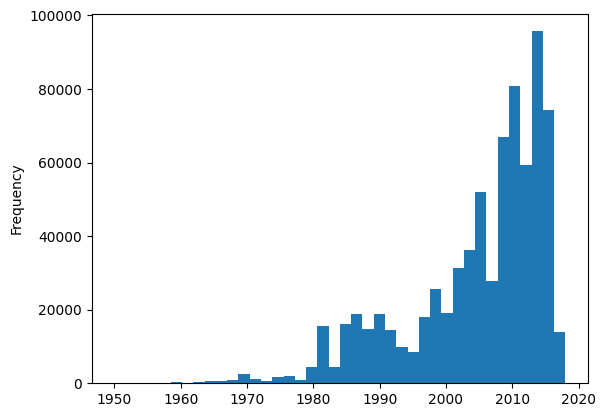

In [31]:
insurance_data["PROD_YEAR"].plot(kind='hist', bins=40)

There are no abnormalities in this attribute.

### Number of seats

In [32]:
insurance_data["SEATS_NUM"].describe()

count    739323.000000
mean          6.173605
std          13.726818
min           0.000000
25%           1.000000
50%           4.000000
75%           4.000000
max         199.000000
Name: SEATS_NUM, dtype: float64

In [33]:
insurance_data["SEATS_NUM"].value_counts()

SEATS_NUM
4.0      211613
1.0      142817
2.0       90399
3.0       82427
0.0       53879
          ...  
125.0         1
199.0         1
112.0         1
72.0          1
71.0          1
Name: count, Length: 94, dtype: int64

There are a total of 53866 vehicles with 0 seats which is impossible. Also, the number of seats should not exceed 256 (seats in the largest bus in the world). Other values will be considered correct.

In [34]:
insurance_data = insurance_data[(insurance_data["SEATS_NUM"] > 0) & (insurance_data["SEATS_NUM"] <= 256)]

print(insurance_data.shape)

(685444, 19)


### Carrying capacity

In [35]:
insurance_data["CARRYING_CAPACITY"].value_counts()

CARRYING_CAPACITY
0.0        206940
7.0         55346
10.0        33951
3.0         23894
6.0         20817
            ...  
10005.0         1
33.9            1
20164.0         1
10632.0         1
6630.0          1
Name: count, Length: 2142, dtype: int64

It is clear that the seat number variable and the carrying capacity variable are not clearly differentiated. They have been mixed up and should be removed.

In [36]:
insurance_data.drop(columns=["SEATS_NUM", "CARRYING_CAPACITY"], inplace=True)

### Vehicle type

In [37]:
insurance_data["TYPE_VEHICLE"].value_counts()

TYPE_VEHICLE
Motor-cycle                  138147
Truck                        133820
Pick-up                      128905
Automobile                   113938
Bus                           98710
Station Wagones               51191
Tanker                         9006
Special construction           7153
Tractor                        4041
Trailers and semitrailers       533
Name: count, dtype: int64

Nothing out of the ordinary here.

### Vehicle Weight

In [38]:
insurance_data["CCM_TON"].describe()

count    685444.000000
mean       3258.295956
std        3392.265989
min           0.000000
25%         790.000000
50%        2494.000000
75%        4164.000000
max       20000.000000
Name: CCM_TON, dtype: float64

In [39]:
insurance_data["CCM_TON"].value_counts()

CCM_TON
4164.0    52168
0.0       39414
2494.0    38604
200.0     30761
4334.0    24197
          ...  
9680.0        1
1692.0        1
690.0         1
5216.0        1
5189.0        1
Name: count, Length: 3608, dtype: int64

This variable is related to the weight of the vehicle. Since it is not clearly described how and what units are being used, we will remove it.

In [40]:
insurance_data.drop(columns=["CCM_TON"], inplace=True)

### Vehicle maker

In [41]:
insurance_data["MAKE"].value_counts()

MAKE
TOYOTA              244348
ISUZU                69448
BAJAJI               67072
NISSAN               30930
BAJAJ                17679
                     ...  
DONG FENGSHEN            1
AUTOBUS                  1
TOYOTA MERCHEDIS         1
CHINA-ZOTYE              1
KAMA                     1
Name: count, Length: 657, dtype: int64

In [42]:
insurance_data["MAKE"].value_counts()[insurance_data["MAKE"].value_counts() <= 200]

MAKE
CHANA               200
TRAKER              196
DISCOVERY           191
LOADER              189
MASIL FERGUSAN      187
                   ... 
DONG FENGSHEN         1
AUTOBUS               1
TOYOTA MERCHEDIS      1
CHINA-ZOTYE           1
KAMA                  1
Name: count, Length: 556, dtype: int64

There is a large number of vehicle maker names that are not representative of the manufacturer or are miss-spellings of the brand name, with 'TOYOTA MERCHEDIS' being the most humorous one. Since there is a total number of 657 unique brands, individual corrections would be too cumbersome. Instead, we can use a list of car names and check for matches in the dataset.

We will scrape a complete list of car brands from a car brand [website](https://www.carlogos.org/).

In [43]:
url = "https://www.carlogos.org/car-brands-a-z/"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/115.0.0.0 Safari/537.36"
    )
}

response = requests.get(url, headers=headers)
response.raise_for_status()

soup = BeautifulSoup(response.text, "html.parser")

brands = []

for dd in soup.find_all("dd"):
    a_tag = dd.find("a")
    if a_tag and a_tag.text.strip():
        brands.append(a_tag.text.strip())

brands = list(dict.fromkeys(brands))

print(brands)

len(brands)

['Europe', 'USA', 'JPN', 'GER', 'ITA', 'UK', 'FRA', 'KOR', 'CHN', 'AUS', 'RUS', 'ESP', 'SWE', 'IND', 'Other', 'Popular', 'Luxury', 'Sports Cars', 'Supercars', 'Electric', 'Trucks', 'Abadal', 'Abarth', 'Abbott-Detroit', 'ABT', 'AC', 'Acura', 'Aiways', 'Aixam', 'Alfa Romeo', 'Alpina', 'Alpine', 'Alta', 'Alvis', 'AMC', 'Apollo', 'Arash', 'Arcfox', 'Ariel', 'ARO', 'Arrival', 'Arrinera', 'Artega', 'Ascari', 'Askam', 'Aspark', 'Aston Martin', 'Atalanta', 'Auburn', 'Audi', 'Audi Sport', 'Austin', 'Autobacs', 'Autobianchi', 'Axon', 'BAC', 'BAIC Motor', 'Baojun', 'BeiBen', 'Bentley', 'Berkeley', 'Berliet', 'Bertone', 'Bestune', 'BharatBenz', 'Bitter', 'Bizzarrini', 'BMW', 'BMW M', 'Borgward', 'Bowler', 'Brabus', 'Brammo', 'Brilliance', 'Bristol', 'Brooke', 'Bufori', 'Bugatti', 'Buick', 'BYD', 'Byton', 'Cadillac', 'CAMC', 'Canoo', 'Caparo', 'Carlsson', 'Caterham', 'Changan', 'Changfeng', 'Chery', 'Chevrolet Corvette', 'Chevrolet', 'Chrysler', 'Cisitalia', 'Citroën', 'Cizeta', 'Cole', 'Corre La L

412

The website states that there are 383 car brands on the website. The beginning of the list contains countries and the end contains other unrelated text. That should prove easy to clean.

In [44]:
brands_clean = brands[21:-8]

remove_list = ["Mercedes-Benz", "Audi Sport", "BMW M", "Chevrolet Corvette", "Ford Mustang", "Nissan GT-R", "Toyota Alphard", "Toyota Century", "Toyota Crown"]
brands_clean = [b for b in brands_clean if b not in remove_list]

brands_clean = ["Mercedes" if b == "Mercedes-AMG" else b for b in brands_clean]

print(brands_clean)

len(brands_clean)

['Abadal', 'Abarth', 'Abbott-Detroit', 'ABT', 'AC', 'Acura', 'Aiways', 'Aixam', 'Alfa Romeo', 'Alpina', 'Alpine', 'Alta', 'Alvis', 'AMC', 'Apollo', 'Arash', 'Arcfox', 'Ariel', 'ARO', 'Arrival', 'Arrinera', 'Artega', 'Ascari', 'Askam', 'Aspark', 'Aston Martin', 'Atalanta', 'Auburn', 'Audi', 'Austin', 'Autobacs', 'Autobianchi', 'Axon', 'BAC', 'BAIC Motor', 'Baojun', 'BeiBen', 'Bentley', 'Berkeley', 'Berliet', 'Bertone', 'Bestune', 'BharatBenz', 'Bitter', 'Bizzarrini', 'BMW', 'Borgward', 'Bowler', 'Brabus', 'Brammo', 'Brilliance', 'Bristol', 'Brooke', 'Bufori', 'Bugatti', 'Buick', 'BYD', 'Byton', 'Cadillac', 'CAMC', 'Canoo', 'Caparo', 'Carlsson', 'Caterham', 'Changan', 'Changfeng', 'Chery', 'Chevrolet', 'Chrysler', 'Cisitalia', 'Citroën', 'Cizeta', 'Cole', 'Corre La Licorne', 'Dacia', 'Daewoo', 'DAF', 'Daihatsu', 'Daimler', 'Dartz', 'Datsun', 'David Brown', 'Dayun', 'De Tomaso', 'Delage', 'DeSoto', 'Detroit Electric', 'Devel Sixteen', 'Diatto', 'DINA', 'DKW', 'DMC', 'Dodge', 'Dodge Viper'

374

We can now look for matching brands in our dataset. For that we will use the fuzzywuzzy library and search for matches using the Levenshtein distance.

In [45]:
insurance_data = insurance_data[insurance_data["MAKE"].str.strip() != '*']

In [46]:
unique_makes = insurance_data["MAKE"].unique()

def match_brand(brand):
    match, score = process.extractOne(brand, brands_clean)
    if 60 < score < 80:
        print(brand, match)
    return match if score >= 80 else 'UNKNOWN'

mapping = {make: match_brand(make) for make in unique_makes}

MERCEEDICE Mercedes
TOMSON De Tomaso
ROZA Irizar
CRANE Corre La Licorne
TRAKKER ERF
ABAY Abadal
ORAL Fioravanti
DUNGFING Dongfeng
VERYCA Venucia
AMBULANCE Lancia
GEEP Jeep
SINO HOWO Hino
BOXER Bowler
BARTOLETI Cole
MTE MEV
DAMAS Daihatsu
ASIA TOPIC Fiat
NIVA Scania
FARID Faraday Future
PREGIO Iso
PEAGOUT Peugeot
VITZ Navistar
MESFIN Elfin
TICO IKCO
ATOZ Singulato
CALABRASE Alta
MASSENZA Maserati
AEOLUS Melkus
SPORTAGE Geo
LAND CRUISER Land Rover
STEYER ERF
CALABRESE Alta
WHEEL LOADER ERF
SOCOOL Cole
NATFA FAW
BELARUS Elva
ZONGSHEN Dongfeng
TVS TVR
OTOYOL Toyota
T0Y0TA Toyota
ADGE Delage
CLASS SSC
TRAILER ERF
BRIDGE Geo
SKY BUS IC Bus
TRAKER ERF
PLATENA Artega
CATERPILLAR Cadillac
ARMORDE Ford
REXTON Axon
WINEGEL Singer
NEW HOLLAND Lada
LISBO Iso
LANOS Hispano-Suiza
CAT DOZER ERF
LOADER ERF
VERCYA Mercury
DUNGFINF Dongfeng
ZMAY Maybach
ROLFO FSO
VERSATILE SEAT
MARU Aston Martin
POWER PLUS DOSER Setra
RED FOX Arcfox
TAXI Hawtai
FORLAND Ford
CHINA Changan
CHANGHE Changfeng
CORE DRILLING R

We can review and map the remaining brands that were not detected as matches manually.

In [47]:
manual_mapping = {
    "MERCEEDICE": "Mercedes",
    "MERCEEDES": "Mercedes",
    "MERCHEDES": "Mercedes",
    "MERCEDICE": "Mercedes",
    "MERCEDIS": "Mercedes",
    "DUNGFING": "Dongfeng",
    "GEEP": "Jeep",
    "PEAGOUT": "Peugeot",
    "PAGOT": "Peugeot",
    "PEJOT": "Peugeot",
    "LAND CRUISER": "Toyota",
    "T0Y0TA": "Toyota",
    "COROLLA": "Toyota",
    "RAV4": "Toyota",
    "VOLSVAGON": "Volkswagen",
    "PASSAT": "Volkswagen",
    "HYUNDI GETZ": "Hyundai",
    "DISCOVER": "Land Rover",
    "FOED": "Ford",
    "BMB": "BMW"
}

combined_mapping = {**mapping, **manual_mapping}

insurance_data["MANUFACTURER"] = insurance_data["MAKE"].map(mapping)

In [48]:
insurance_data["MANUFACTURER"].unique()

array(['Toyota', 'Mitsubishi', 'Iveco', 'Fiat', 'Isuzu', 'Mercedes',
       'Nissan', 'Bizzarrini', 'Rover', 'BMW', 'UNKNOWN', 'Suzuki',
       'Daihatsu', 'DAF', 'Sinotruk', 'Higer', 'Ford', 'Peugeot',
       'Volkswagen', 'Daewoo', 'FAW Jiefang', 'Renault', 'IC Bus',
       'International', 'Tauro', 'Scania', 'Volvo', 'Datsun',
       'Land Rover', 'Tata', 'Hino', 'Opel', 'Hyundai', 'Chevrolet',
       'Honda', 'Lada', 'Mazda', 'Dacia', 'Kia', 'Alfa Romeo', 'AC',
       'Dayun', 'GMC', 'Setra', 'Foton', 'Audi', 'Mahindra', 'Mack',
       'FAW', 'Škoda', 'Lifan', 'Chery', 'Lexus', 'Geely', 'Zotye', 'MAZ',
       'Cadillac', 'Kamaz', 'JAC', 'Mini', 'Arash', 'MAN', 'Citroën',
       'Autobacs', 'Hongyan', 'Force Motors', 'ARO', 'Wuling',
       'Great Wall', 'Caterham', 'Jeep', 'Pontiac', 'Changan', 'Troller',
       'UD', 'Saab', 'Dongfeng', 'W Motors', 'Dodge', 'RAM', 'Lancia',
       'Cole', 'Eicher', 'JMC', 'Roewe', 'Shacman', 'Landwind', 'Hummer',
       'King Long', 'Infiniti', 'H

### Primary function of vehicle

In [49]:
insurance_data["USAGE"].value_counts()

USAGE
Own Goods                 181574
Private                   180903
Fare Paying Passengers    115320
General Cartage            93315
Taxi                       46512
Own service                44365
Others                      8312
Special Construction        3154
Ambulance                   2931
Learnes                     2624
Car Hires                   2391
Agricultural Own Farm       2299
Agricultural Any Farm       1641
Fire fighting                102
Name: count, dtype: int64

All functions seem valid.

### Paid claim sum

In [50]:
insurance_data["CLAIM_PAID"] = insurance_data["CLAIM_PAID"].replace(np.nan, 0)

pd.set_option('display.float_format', '{:.2f}'.format)

print(insurance_data["CLAIM_PAID"].describe())

count      685443.00
mean        19113.32
std        433982.33
min             0.00
25%             0.00
50%             0.00
75%             0.00
max     152445764.90
Name: CLAIM_PAID, dtype: float64


In [51]:
insurance_data["CLAIM_PAID"].median()

np.float64(0.0)

In [52]:
len(insurance_data[insurance_data["CLAIM_PAID"] == 0])

633795

The payout values seem realistic since they are in Ethiopian birr. The largest paid sum is around 1,100,000 USD and the median no payout at all (0 USD).

### Insurance premium

The premium amounts are provided in Ethiopian birr (1000 Birr = 7,3 USD).

In [53]:
insurance_data["PREMIUM"][insurance_data["PREMIUM"] <= 0].count()

np.int64(10)

There are 29 vehicles with a premium of 0 or less. This is not acceptable and we will remove them. I was informed by the publisher of the dataset that the company follows a principle of "No premium, no insurance". This method of record keeping is ineffective.

In [54]:
insurance_data = insurance_data[insurance_data["PREMIUM"] > 0]

insurance_data["PREMIUM"].describe()

count   685414.00
mean      7440.73
std      10866.36
min          2.98
25%        726.75
50%       3016.30
75%       9611.27
max     330818.54
Name: PREMIUM, dtype: float64

From the variable description it becomes clear that it is nowhere close to normality.

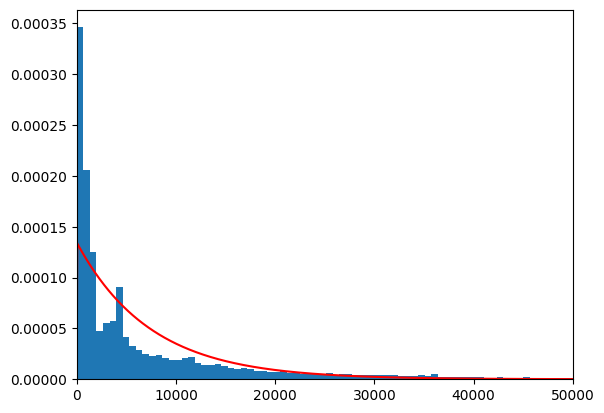

In [55]:
params = expon.fit(insurance_data["PREMIUM"])

x = np.linspace(0, 50000, 1000)
pdf = expon.pdf(x, *params)

plt.hist(insurance_data["PREMIUM"], bins=500, density=True)
plt.plot(x, pdf, 'r')
plt.xlim([0, 50000])
plt.show()

The distribution closely resembles an exponential one.

In [56]:
D, p_value = kstest(insurance_data["PREMIUM"], 'expon', args=params)

print(f"P-value: {p_value:.4f}")

P-value: 0.0000


As the p-value is less than 0.05, we fail to reject the null hypothesis. This distribution might as well exponential.

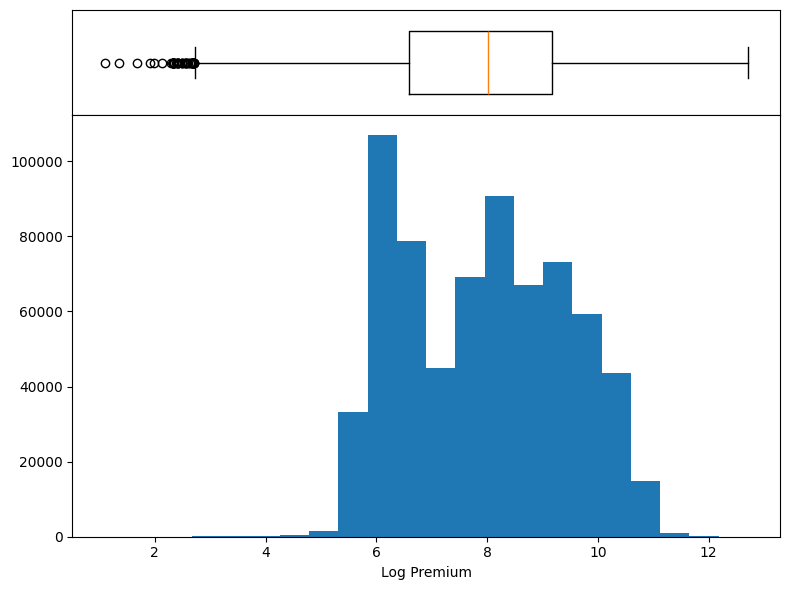

In [57]:
log_premiums = np.log(insurance_data["PREMIUM"])

fig, axes = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 4]})

axes[0].boxplot(log_premiums, vert=False, widths=0.6)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].hist(log_premiums, bins=22)
axes[1].set_xlabel('Log Premium')

plt.tight_layout(h_pad=0)

plt.show()

### Modelling

In [58]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 685414 entries, 8 to 802035
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SEX               685414 non-null  object        
 1   INSR_BEGIN        685414 non-null  datetime64[ns]
 2   INSR_END          685414 non-null  datetime64[ns]
 3   INSR_TYPE         685414 non-null  object        
 4   INSURED_VALUE     685414 non-null  float64       
 5   PREMIUM           685414 non-null  float64       
 6   OBJECT_ID         685414 non-null  int64         
 7   PROD_YEAR         685411 non-null  float64       
 8   TYPE_VEHICLE      685414 non-null  object        
 9   MAKE              685414 non-null  object        
 10  USAGE             685414 non-null  object        
 11  CLAIM_PAID        685414 non-null  float64       
 12  INSR_START_MONTH  685414 non-null  int32         
 13  INSR_START_YEAR   685414 non-null  int32         
 14  INSR_STAR

We are left with 12 variables that could be used for modelling: SEX, INSR_TYPE, INSURED_VALUE, PROD_YEAR, TYPE_VEHICLE, MAKE, USAGE, CLAIM_PAID, INSR_COVER, INSR_START_DAY, INSR_START_MONTH and INSR_START_YEAR.

In [59]:
model = LinearRegression()

X = insurance_data[["INSR_TYPE", "INSURED_VALUE", "CLAIM_PAID", "INSR_COVER", "MANUFACTURER"]].copy()

X = pd.get_dummies(X, columns=["INSR_TYPE", "INSR_COVER", "MANUFACTURER"], drop_first=True)

Y = insurance_data["PREMIUM"]

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=87)

model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

r_sq = model.score(X_test, Y_test)

mae = sk.metrics.mean_absolute_error(Y_test, Y_pred)

r_sq, mae

(0.6101633569424476, np.float64(3807.9706544326195))

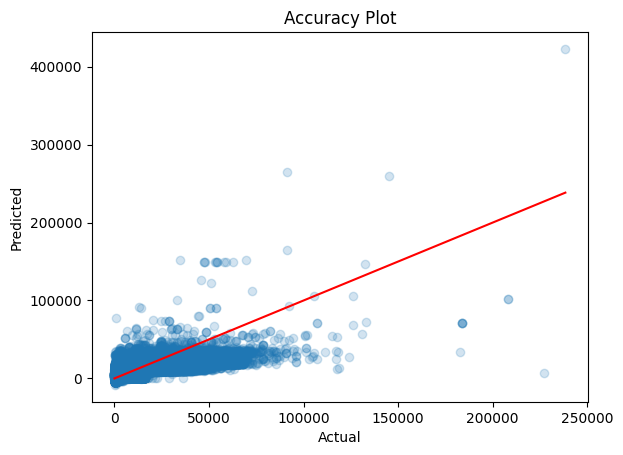

In [60]:
plt.scatter(Y_test, Y_pred, alpha=0.2)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r')
plt.title("Accuracy Plot")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

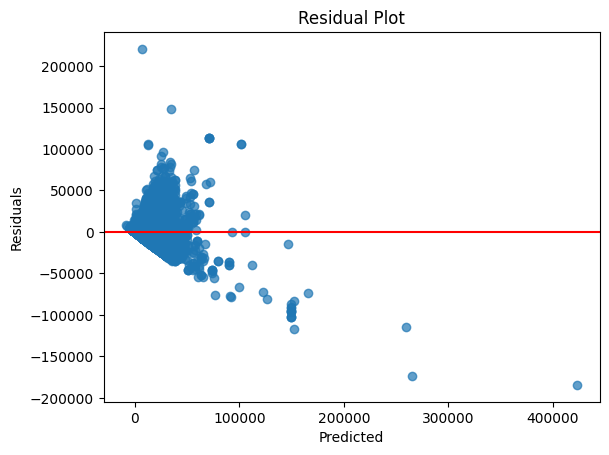

In [61]:
plt.scatter(Y_pred, Y_test - Y_pred, alpha=0.7)
plt.axhline(y=0, color='r')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [62]:
correlation = np.corrcoef(Y_test, Y_pred)[0, 1]
print(f"Correlation: {correlation:.2f}")

Correlation: 0.78


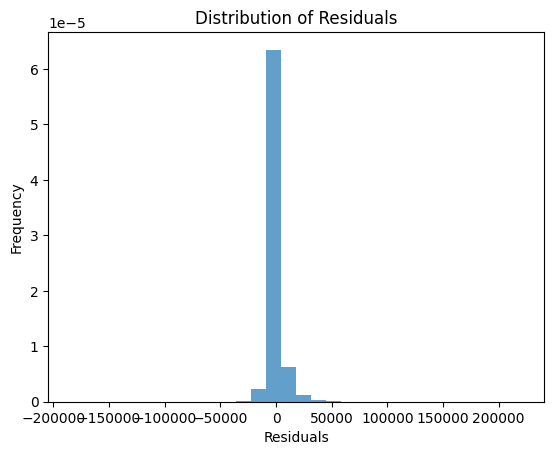

In [63]:
plt.hist(Y_test - Y_pred, bins=30, density=True, alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()